**Objetivo**. Construir un modelo que prediga la *ff. spp.* basado en árboles de
decisión que pueda generalizar lo mejor posible usando los datos de abundancia
de clústeres biosintéticos. Luego, identificar qué clústeres parecen tener
mayor influencia sobre el modelo.

In [1]:
%cd ..

/home/anton/pancluster


In [50]:
import itertools as it

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree, model_selection, metrics

Leemos los datos y removemos las filas de las muestras mexicanas para entrenar
un modelo solamente con las formas especiales de NCBI.

In [3]:
data = pd.read_csv("data/tables/gcf-table.csv", index_col=0)
data.dropna(inplace=True)
data

,fsp,1999,2470,2502,2541,2542,2559,2587,2598,2676,...,14155,14156,14162,14170,14179,14180,14184,14185,14192,14193
GCA_001519035.1,conglutinans,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_002711385.1,conglutinans,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_002711405.2,conglutinans,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_014154955.1,conglutinans,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_018894095.1,conglutinans,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_030719095.1,vasinfectum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_032878545.1,vasinfectum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_032991405.1,vasinfectum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_038050555.1,vasinfectum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


El conjunto de datos es muy desbalanceado.

In [4]:
target = data.pop("fsp")
target.value_counts()

fsp
melonis         53
fragariae       38
niveum          33
vasinfectum     31
lycopersici     30
cubense         17
lini            11
spinaciae       11
conglutinans     9
cucumerinum      9
Name: count, dtype: int64

Quitamos columnas donde todas las filas tienen el mismo valor.

In [5]:
data = data.loc[:, data.nunique() != 1].copy()
data

,2502,2541,2542,2559,2587,2598,2676,2781,2782,2786,...,13636,13650,13680,13752,13761,13775,13818,13823,13952,13977
GCA_001519035.1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
GCA_002711385.1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
GCA_002711405.2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
GCA_014154955.1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
GCA_018894095.1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_030719095.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
GCA_032878545.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
GCA_032991405.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
GCA_038050555.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [6]:
def parameter_combinations(grid: dict):
    for combination in it.product(*grid.values()):
        yield dict(zip(grid.keys(), combination))

In [7]:
def expand_tree_grid(grid: dict, X: np.ndarray, y: np.ndarray):
    new_parameters = []
    for parameters in parameter_combinations(grid):
        ccp_alphas = (
            tree.DecisionTreeClassifier(random_state=0, **parameters)
            .cost_complexity_pruning_path(X, y).ccp_alphas
        )
        parameters["ccp_alphas"] = np.unique(ccp_alphas)
        new_parameters.append(parameters)
    return new_parameters

In [8]:
outer_cv = model_selection.StratifiedKFold(4, shuffle=True, random_state=0)
inner_cv = model_selection.StratifiedKFold(3, shuffle=True, random_state=0)

In [9]:
X = data.iloc[next(outer_cv.split(data, target))[0]]
y = target.iloc[next(outer_cv.split(data, target))[0]]

In [15]:
grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_features": [None, "sqrt", "log2"],
    "class_weight": [None, "balanced"],
    "ccp_alpha": [2]
}

In [14]:
max(dictionary["ccp_alphas"].max() for dictionary in expand_tree_grid(grid, X, y))

for dictionary in expand_tree_grid(grid, X, y):
    print(dictionary["ccp_alphas"].max())

0.160276020911707
0.09999999999999953
0.07691866266879244
0.09999999999999998
0.07740582774355398
0.05360162438154176
0.160276020911707
0.10000000000000042
0.12500120744061605
0.0911894273127779
0.09095074936662484
0.05652938362064438
0.6278803029245892
0.6399668097993154
0.3727815984560445
0.4777049764098995
0.32688568579805866
0.2989670027219773
0.6278803029245892
0.6399668097993154
0.49380299782160186
0.40289263922446983
0.3529752693855097
0.33362333276492606
0.6278803029245892
0.6399668097993154
0.3727815984560445
0.4777049764098995
0.32688568579805866
0.2989670027219773
0.6278803029245892
0.6399668097993154
0.49380299782160186
0.40289263922446983
0.3529752693855097
0.33362333276492606


In [ ]:
results = []

outer_split = outer_cv.split(data, target)

for outer_train_index, outer_test_index in outer_split:

    outer_train_data: pd.DataFrame = data.iloc[outer_train_index]
    outer_train_target: pd.Series = target.iloc[outer_train_index]
    outer_test_data: pd.DataFrame = data.iloc[outer_test_index]
    outer_test_target: pd.Series = target.iloc[outer_test_index]
    inner_split = inner_cv.split(outer_train_data, outer_train_target)

    # for parameters in parameter_combinations(grid):
    #     for inner_train_index, inner_test_index in inner_split:

    #         inner_train_data: pd.DataFrame = (
    #             outer_train_data.iloc[inner_train_index]
    #         )
    #         inner_train_target: pd.Series = (
    #             outer_train_target.iloc[inner_train_index]
    #         )

    #         inner_test_data: pd.DataFrame = (
    #             outer_train_data.iloc[inner_test_index]
    #         )
    #         inner_test_target: pd.Series = (
    #             outer_train_target.iloc[inner_test_index]
    #         )

    #         ccp_alphas: np.ndarray = (
    #             tree.DecisionTreeClassifier(random_state=0, **parameters)
    #             .cost_complexity_pruning_path(
    #                 inner_train_data, inner_train_target
    #             )
    #             .ccp_alphas
    #         )

    #         for ccp_alpha in ccp_alphas:
    #             model = tree.DecisionTreeClassifier(
    #                 random_state=0, ccp_alpha=ccp_alpha, **parameters
    #             ).fit(inner_train_data, inner_train_target)
    #             performance = metrics.matthews_corrcoef(
    #                 inner_test_target, model.predict(inner_test_data)
    #             )
    #             results.append({
    #                 **parameters,
    #                 "ccp_alpha": ccp_alpha,
    #                 "performance": performance
    #             })
    #             break
    #         break
    #     break
    # break
results
# metrics.matthews_corrcoef(inner_test_target, model.predict(inner_test_data))

[{'criterion': 'gini',
  'splitter': 'best',
  'max_features': None,
  'class_weight': None,
  'ccp_alpha': 0.0,
  'performance': 0.7943636181494547},
 {'criterion': 'gini',
  'splitter': 'best',
  'max_features': None,
  'class_weight': 'balanced',
  'ccp_alpha': 0.0,
  'performance': 0.7405340450667243},
 {'criterion': 'gini',
  'splitter': 'best',
  'max_features': 'sqrt',
  'class_weight': None,
  'ccp_alpha': 0.0,
  'performance': 0.6114340259253466},
 {'criterion': 'gini',
  'splitter': 'best',
  'max_features': 'sqrt',
  'class_weight': 'balanced',
  'ccp_alpha': 0.0,
  'performance': 0.5957750879235675},
 {'criterion': 'gini',
  'splitter': 'best',
  'max_features': 'log2',
  'class_weight': None,
  'ccp_alpha': 0.0,
  'performance': 0.7313386471491967},
 {'criterion': 'gini',
  'splitter': 'best',
  'max_features': 'log2',
  'class_weight': 'balanced',
  'ccp_alpha': 0.0,
  'performance': 0.6269819344639986},
 {'criterion': 'gini',
  'splitter': 'random',
  'max_features': Non

In [25]:
# Con cuatro folds estratificados aseguramos que en el test haya alrededor de
# dos muestras para las ff. spp. mas raras (conglutinans y cucumerinum)
cv = model_selection.StratifiedKFold(4, shuffle=True, random_state=0)
estimator = tree.DecisionTreeClassifier(random_state=0)

In [26]:
target.iloc[next(cv.split(data, target))[0]].value_counts()

fsp
melonis         40
fragariae       28
niveum          25
vasinfectum     23
lycopersici     22
cubense         13
lini             9
spinaciae        8
cucumerinum      7
conglutinans     6
Name: count, dtype: int64

In [27]:
grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_features": [None, "sqrt", "log2"],
    "class_weight": [None, "balanced"]
}

In [28]:
grid_search = model_selection.GridSearchCV(
    estimator=estimator,
    param_grid=grid,
    scoring="matthews_corrcoef",
    cv=cv
)

In [29]:
grid_search.fit(data, target)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': [None, 'sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             scoring='matthews_corrcoef')

In [31]:
model = tree.DecisionTreeClassifier(
    random_state=0,
    splitter="best",
    ccp_alpha=0.10087564
)

In [30]:
grid_search.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_features': None,
 'splitter': 'random'}

In [34]:
train_index, test_index = next(cv.split(data, target))
test_index

array([  1,   2,   7,  10,  11,  14,  19,  30,  33,  46,  47,  49,  50,
        53,  56,  61,  62,  64,  71,  74,  76,  84,  91,  92,  94,  95,
       103, 106, 107, 115, 121, 124, 129, 134, 135, 137, 138, 150, 152,
       154, 160, 166, 172, 173, 174, 180, 185, 186, 189, 192, 200, 207,
       208, 213, 214, 216, 222, 223, 228, 230, 239])

In [37]:
data.iloc[test_index]

,2502,2541,2542,2559,2587,2598,2676,2781,2782,2786,...,13636,13650,13680,13752,13761,13775,13818,13823,13952,13977
GCA_002711385.1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
GCA_002711405.2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
GCA_000222805.1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
GCA_005930515.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
GCA_007994515.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_025216185.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
GCA_025216345.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
GCA_025216465.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
GCA_025216505.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [45]:
model = tree.DecisionTreeClassifier(random_state=0, splitter="random")

In [38]:
model.fit(data.iloc[train_index], target.iloc[train_index])

DecisionTreeClassifier(random_state=0, splitter='random')

In [65]:
ccp_alphas: np.ndarray = np.unique(model.cost_complexity_pruning_path(
    data, target
).ccp_alphas)
ccp_alphas

array([0.        , 0.00413223, 0.00619835, 0.00708383, 0.00757576,
       0.0079693 , 0.00798898, 0.0080062 , 0.00895317, 0.00991736,
       0.01287349, 0.0179805 , 0.01885331, 0.02051282, 0.02125148,
       0.02368547, 0.02736841, 0.03256693, 0.03393516, 0.04844953,
       0.05934571, 0.10087564, 0.10842755, 0.15484674])

In [66]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(
        random_state=0, splitter="random", ccp_alpha=ccp_alpha
    )
    clf.fit(data.iloc[train_index], target.iloc[train_index])
    clfs.append(clf)

In [67]:
train_mccs = [metrics.matthews_corrcoef(
        target.iloc[train_index], clf.predict(data.iloc[train_index])
) for clf in clfs]
test_mccs = [metrics.matthews_corrcoef(
        target.iloc[test_index], clf.predict(data.iloc[test_index])
) for clf in clfs]

In [68]:
len(ccp_alphas)

24

[0.         0.00413223 0.00619835 0.00708383 0.00757576 0.0079693
 0.00798898 0.0080062  0.00895317 0.00991736 0.01287349 0.0179805
 0.01885331 0.02051282 0.02125148 0.02368547 0.02736841 0.03256693
 0.03393516 0.04844953 0.05934571 0.10087564 0.10842755 0.15484674]
[0.7938863796236679, 0.7938863796236679, 0.7560124594046043, 0.7560124594046043, 0.7359620820249176, 0.7359620820249176, 0.7359620820249176, 0.7359620820249176, 0.7170486287666681, 0.7170486287666681, 0.7351228662583964, 0.7213787891636175, 0.7213787891636175, 0.7213787891636175, 0.7213787891636175, 0.7028385957536251, 0.6581266218599381, 0.6728552101309929, 0.6728552101309929, 0.6211830747342502, 0.5742445279331712, 0.41839507476468596, 0.41839507476468596, 0.32013627534922867]


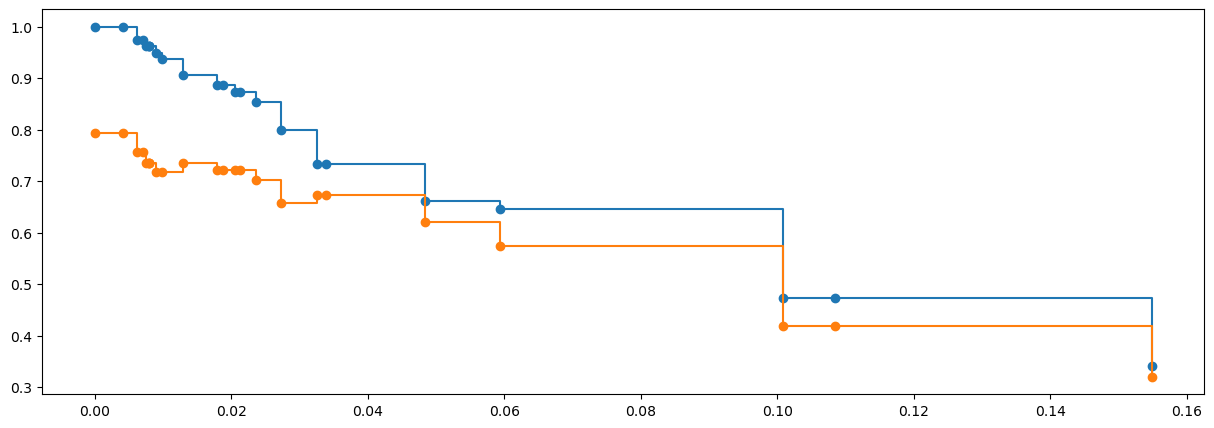

In [70]:
plt.figure(figsize=(15, 5))
plt.plot(ccp_alphas, train_mccs, marker="o", drawstyle="steps-post")
plt.plot(ccp_alphas, test_mccs, marker="o", drawstyle="steps-post")
print(ccp_alphas)
print(test_mccs)

In [71]:
final_tree = tree.DecisionTreeClassifier(
    random_state=0, splitter="random", ccp_alpha=0.004
).fit(data, target)

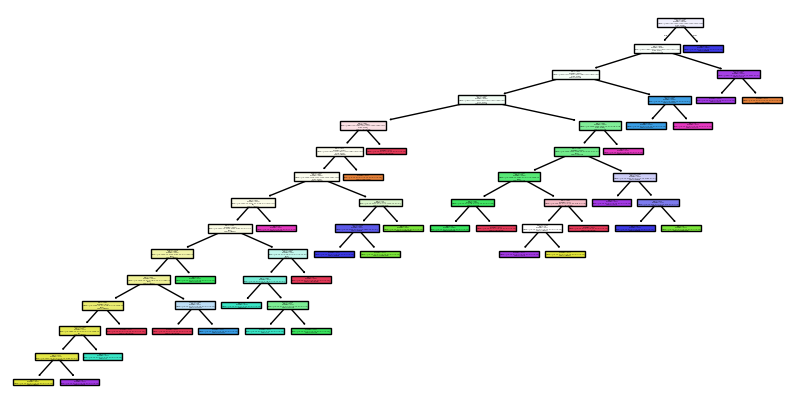

In [101]:
plt.figure(figsize=(10, 5))
tree.plot_tree(
    final_tree, filled=True, proportion=True, class_names=final_tree.classes_,
    feature_names=final_tree.feature_names_in_)
plt.savefig("tree.svg")

In [84]:
final_tree.classes_

array(['conglutinans', 'cubense', 'cucumerinum', 'fragariae', 'lini',
       'lycopersici', 'melonis', 'niveum', 'spinaciae', 'vasinfectum'],
      dtype=object)

In [93]:
final_tree.feature_importances_.argmax()

245

In [100]:
data.iloc[:, final_tree.feature_importances_.argsort()[::-1]]

,10614,3728,4094,7674,3066,11737,2587,8164,6035,6127,...,9983,10170,10172,10194,10195,10204,10209,10210,10214,2502
GCA_001519035.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
GCA_002711385.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
GCA_002711405.2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_014154955.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
GCA_018894095.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_030719095.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
GCA_032878545.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_032991405.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_038050555.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
data.columns.copy(deep=True)[final_tree.feature_importances_.argsort()[::-1]]

Index(['10614', '3728', '4094', '7674', '3066', '11737', '2587', '8164',
       '6035', '6127',
       ...
       '9983', '10170', '10172', '10194', '10195', '10204', '10209', '10210',
       '10214', '2502'],
      dtype='object', length=345)

In [94]:
data[data.columns[245]]

GCA_001519035.1    0.0
GCA_002711385.1    0.0
GCA_002711405.2    0.0
GCA_014154955.1    0.0
GCA_018894095.1    0.0
                  ... 
GCA_030719095.1    0.0
GCA_032878545.1    0.0
GCA_032991405.1    0.0
GCA_038050555.1    0.0
GCA_000260175.2    0.0
Name: 10614, Length: 242, dtype: float64